In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
import os
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

2025-08-14 15:35:30.149675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755185730.371417      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755185730.437956      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

os.environ["WANDB_DISABLED"] = "true"
data_path = "/kaggle/input/nlp-stock-data/indo_raw_with_emoji.csv"
label_encoder = LabelEncoder()

In [3]:
hyperparameter_configs = [
    {'id': 'Config_A_LR5e-5_BS8_WD0.01', 'learning_rate': 5e-5, 'batch_size': 8, 'weight_decay': 0.01},
    {'id': 'Config_B_LR2e-5_BS8_WD0.01', 'learning_rate': 2e-5, 'batch_size': 8, 'weight_decay': 0.01},
    {'id': 'Config_C_LR5e-5_BS8_WD0.0',  'learning_rate': 5e-5, 'batch_size': 8, 'weight_decay': 0.0},
    {'id': 'Config_D_LR2e-5_BS8_WD0.0',  'learning_rate': 2e-5, 'batch_size': 8, 'weight_decay': 0.0},
    
    {'id': 'Config_E_LR5e-5_BS16_WD0.01', 'learning_rate': 5e-5, 'batch_size': 16, 'weight_decay': 0.01},
    {'id': 'Config_F_LR2e-5_BS16_WD0.01', 'learning_rate': 2e-5, 'batch_size': 16, 'weight_decay': 0.01},
    {'id': 'Config_G_LR5e-5_BS16_WD0.0',  'learning_rate': 5e-5, 'batch_size': 16, 'weight_decay': 0.0},
    {'id': 'Config_H_LR2e-5_BS16_WD0.0',  'learning_rate': 2e-5, 'batch_size': 16, 'weight_decay': 0.0},
]

EPOCHS = 5

In [4]:
df = pd.read_csv(data_path)
df.dropna(subset=['Processed_Sentence', 'Sentiment'], inplace=True)

X = df['Processed_Sentence'].tolist()
y = label_encoder.fit_transform(df['Sentiment'])
NUM_LABELS = len(label_encoder.classes_)

print("Label mapping:", {i: label for i, label in enumerate(label_encoder.classes_)})

Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Data split - Train: 2301, Val: 493, Test: 494


# Tokenizer

In [6]:
def setup_bert_model_and_tokenizer(model_name, num_labels=3):
    print(f"\n--- Initializing model and tokenizer from '{model_name}' ---")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    return model, tokenizer

# Model

In [7]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    return {
        'accuracy': accuracy, 
        'f1_macro': f1_macro
    }

In [8]:
def run_training_experiment(model, tokenizer, config, temp_output_dir, X_train, y_train, X_val, y_val):
    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    val_df = pd.DataFrame({'text': X_val, 'label': y_val})

    hf_datasets = DatasetDict({
        'train': Dataset.from_pandas(train_df),
        'validation': Dataset.from_pandas(val_df)
    })

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

    tokenized_datasets = hf_datasets.map(tokenize_function, batched=True)

    training_args = TrainingArguments(
        output_dir=temp_output_dir,
        num_train_epochs=EPOCHS,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        report_to="none",
        logging_strategy="epoch",
        seed=42,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    trainer.train()
    
    eval_f1_scores = [log['eval_f1_macro'] for log in trainer.state.log_history if 'eval_f1_macro' in log]
    best_validation_f1 = max(eval_f1_scores) if eval_f1_scores else -1

    return trainer, best_validation_f1

In [9]:
best_f1_score = -1.0
best_config_id = None
best_model_dir = "/kaggle/working/best_indobert_model"

if os.path.exists(best_model_dir):
    shutil.rmtree(best_model_dir)

In [10]:
for config in hyperparameter_configs:
    print(f"\n{'='*50}")
    print(f"Experiment: {config['id']}")
    print("="*50)

    model, tokenizer = setup_bert_model_and_tokenizer(
        model_name='indolem/indobertweet-base-uncased',
        num_labels=NUM_LABELS
    )
    
    # temporary dir
    temp_dir = f"/kaggle/working/temp_{config['id']}"

    trainer, current_f1 = run_training_experiment(
        model, tokenizer, config, temp_dir, X_train, y_train, X_val, y_val
    )

    print(f"--- Experiment {config['id']} | validation F1-Macro: {current_f1:.4f} ---")
    if current_f1 > best_f1_score:
        print(f"New best model | F1-macro improved {best_f1_score:.4f} --> {current_f1:.4f}")
        best_f1_score = current_f1
        best_config_id = config['id']
        
        if os.path.exists(best_model_dir):
            shutil.rmtree(best_model_dir)
        
        trainer.save_model(best_model_dir)
        tokenizer.save_pretrained(best_model_dir)
        print(f"Saved new model to: {best_model_dir}")
        
    else:
        print(f"Model did not improve from best F1-macro {best_f1_score:.4f}")
    
    shutil.rmtree(temp_dir)

    del model, trainer
    torch.cuda.empty_cache()


Experiment: Config_A_LR5e-5_BS8_WD0.01

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.639000,0.487326,0.837728,0.799778
2,0.294200,0.646627,0.831643,0.807188
3,0.114300,0.824173,0.855984,0.833088
4,0.036700,0.908979,0.862069,0.840114
5,0.029300,0.916188,0.864097,0.843555


--- Experiment Config_A_LR5e-5_BS8_WD0.01 | validation F1-Macro: 0.8436 ---
New best model | F1-macro improved -1.0000 --> 0.8436
Saved new model to: /kaggle/working/best_indobert_model

Experiment: Config_B_LR2e-5_BS8_WD0.01

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.675500,0.432914,0.825558,0.792746
2,0.327200,0.458527,0.855984,0.839074
3,0.171600,0.636326,0.864097,0.839692
4,0.089800,0.654158,0.878296,0.862385
5,0.070300,0.647431,0.880325,0.862941


--- Experiment Config_B_LR2e-5_BS8_WD0.01 | validation F1-Macro: 0.8629 ---
New best model | F1-macro improved 0.8436 --> 0.8629
Saved new model to: /kaggle/working/best_indobert_model

Experiment: Config_C_LR5e-5_BS8_WD0.0

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.613100,0.493477,0.833671,0.804719
2,0.273900,0.635873,0.853955,0.829534
3,0.121900,0.820203,0.864097,0.843199
4,0.042100,0.879871,0.868154,0.852250
5,0.028600,0.863363,0.870183,0.853869


--- Experiment Config_C_LR5e-5_BS8_WD0.0 | validation F1-Macro: 0.8539 ---
Model did not improve from best F1-macro 0.8629

Experiment: Config_D_LR2e-5_BS8_WD0.0

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.691900,0.439673,0.819473,0.787179
2,0.346800,0.455594,0.851927,0.826647
3,0.178900,0.631651,0.858012,0.834859
4,0.099800,0.658756,0.864097,0.847637
5,0.073600,0.675541,0.876268,0.858063


--- Experiment Config_D_LR2e-5_BS8_WD0.0 | validation F1-Macro: 0.8581 ---
Model did not improve from best F1-macro 0.8629

Experiment: Config_E_LR5e-5_BS16_WD0.01

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.647700,0.425989,0.837728,0.811463
2,0.277900,0.440433,0.845842,0.825253
3,0.110200,0.640932,0.858012,0.841164
4,0.044900,0.721636,0.864097,0.846793
5,0.028600,0.724063,0.862069,0.844113


--- Experiment Config_E_LR5e-5_BS16_WD0.01 | validation F1-Macro: 0.8468 ---
Model did not improve from best F1-macro 0.8629

Experiment: Config_F_LR2e-5_BS16_WD0.01

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.731700,0.487802,0.805274,0.773954
2,0.374000,0.417895,0.845842,0.823661
3,0.215900,0.459279,0.855984,0.836115
4,0.125700,0.493782,0.874239,0.854563
5,0.072500,0.524588,0.870183,0.850308


--- Experiment Config_F_LR2e-5_BS16_WD0.01 | validation F1-Macro: 0.8546 ---
Model did not improve from best F1-macro 0.8629

Experiment: Config_G_LR5e-5_BS16_WD0.0

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.651000,0.417002,0.841785,0.815371
2,0.278200,0.484860,0.835700,0.816869
3,0.122500,0.619780,0.862069,0.843080
4,0.050700,0.708604,0.882353,0.865939
5,0.019300,0.729787,0.876268,0.860278


--- Experiment Config_G_LR5e-5_BS16_WD0.0 | validation F1-Macro: 0.8659 ---
New best model | F1-macro improved 0.8629 --> 0.8659
Saved new model to: /kaggle/working/best_indobert_model

Experiment: Config_H_LR2e-5_BS16_WD0.0

--- Initializing model and tokenizer from 'indolem/indobertweet-base-uncased' ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.731300,0.477376,0.811359,0.781881
2,0.368800,0.422843,0.849899,0.827126
3,0.212200,0.453037,0.858012,0.836161
4,0.129800,0.507645,0.866126,0.845693
5,0.074800,0.535508,0.864097,0.844346


--- Experiment Config_H_LR2e-5_BS16_WD0.0 | validation F1-Macro: 0.8457 ---
Model did not improve from best F1-macro 0.8659


In [11]:
print(f"Best Configuration '{best_config_id}' | Validation F1-Macro of {best_f1_score:.4f}")

final_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
final_tokenizer = AutoTokenizer.from_pretrained(best_model_dir)
final_trainer = Trainer(model=final_model)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Best Configuration 'Config_G_LR5e-5_BS16_WD0.0' | Validation F1-Macro of 0.8659


In [13]:
def evaluate_final_model(trainer, tokenizer, X_eval, y_eval, dataset_name):
    eval_df = pd.DataFrame({'text': X_eval, 'label': y_eval})
    eval_dataset = Dataset.from_pandas(eval_df)
    
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

    tokenized_eval = eval_dataset.map(tokenize_function, batched=True)

    predictions = trainer.predict(tokenized_eval)
    y_pred = np.argmax(predictions.predictions, axis=1)

    accuracy = accuracy_score(y_eval, y_pred)
    f1_macro = f1_score(y_eval, y_pred, average='macro')
    print(f"\n--- {dataset_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_eval, y_pred, target_names=label_encoder.classes_, digits=4))

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'predictions': y_pred,
        'classification_report': classification_report(
            y_eval, y_pred, target_names=label_encoder.classes_, digits=4, output_dict=True
        )
    }

In [14]:
train_results = evaluate_final_model(final_trainer, final_tokenizer, X_train, y_train, "Train")
val_results = evaluate_final_model(final_trainer, final_tokenizer, X_val, y_val, "Validation")
test_results = evaluate_final_model(final_trainer, final_tokenizer, X_test, y_test, "Test")

Map:   0%|          | 0/2301 [00:00<?, ? examples/s]


--- Train Results ---
Accuracy: 0.9965
              precision    recall  f1-score   support

    Negative     0.9928    1.0000    0.9964       550
     Neutral     0.9941    0.9903    0.9922       513
    Positive     0.9992    0.9976    0.9984      1238

    accuracy                         0.9965      2301
   macro avg     0.9954    0.9959    0.9956      2301
weighted avg     0.9965    0.9965    0.9965      2301



Map:   0%|          | 0/493 [00:00<?, ? examples/s]


--- Validation Results ---
Accuracy: 0.8824
              precision    recall  f1-score   support

    Negative     0.8281    0.8983    0.8618       118
     Neutral     0.8600    0.7818    0.8190       110
    Positive     0.9170    0.9170    0.9170       265

    accuracy                         0.8824       493
   macro avg     0.8684    0.8657    0.8659       493
weighted avg     0.8830    0.8824    0.8819       493



Map:   0%|          | 0/494 [00:00<?, ? examples/s]


--- Test Results ---
Accuracy: 0.8927
              precision    recall  f1-score   support

    Negative     0.8547    0.8475    0.8511       118
     Neutral     0.8738    0.8182    0.8451       110
    Positive     0.9161    0.9436    0.9296       266

    accuracy                         0.8927       494
   macro avg     0.8815    0.8697    0.8753       494
weighted avg     0.8920    0.8927    0.8920       494



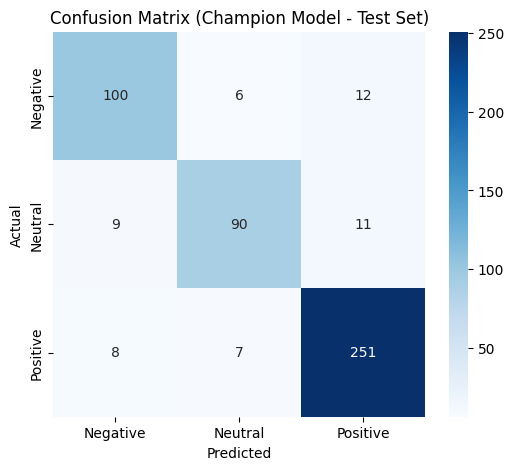

In [16]:
cm = confusion_matrix(y_test, test_results['predictions'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix (Champion Model - Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
wrong_pred_indices = np.where(y_test != test_results)[0]
wrong_predictions_df = pd.DataFrame({
    'Sentence': [X_test[i] for i in wrong_pred_indices],
    'Actual Sentiment': label_encoder.inverse_transform(y_test[wrong_pred_indices]),
    'Predicted Sentiment': label_encoder.inverse_transform(test_results['predictions'][wrong_pred_indices])
})
wrong_predictions_df.to_csv('wrong_predictions_CHAMPION_IndoBERT.csv', index=False)

display(wrong_predictions_df.head())

,Sentence,Actual Sentiment,Predicted Sentiment
0,"Bisnis Agribisnis, keuangan, alat berat, konst...",Neutral,Negative
1,"kalo dari rasio investasi, bisa dilihat memang...",Negative,Negative
2,Bmri mumpung lg koreksi,Positive,Negative
3,"IHSG Masih Melemah Terbatas Besok, Cermati Sah...",Negative,Negative
4,ALL IN $ASII performance perusahaan bagus dan ...,Positive,Positive


In [19]:
import shutil

folder_path = "/kaggle/working/best_indobert_model"
shutil.make_archive("/kaggle/working/best_indobert_model", 'zip', folder_path)

'/kaggle/working/best_indobert_model.zip'